In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
import glob
import operator
#from progress.bar import Bar

In [2]:
class simulation:
    def __init__(self,fname):
        param = self.read_param(fname)
        
        self.train_name   = param[0]
        self.test_name    = param[1]
        self.labels       = int(param[2])
        self.numsites     = int(param[3])
        self.Train_size   = int(param[4])     #<-----4
        self.cutoff       = int(param[5])     #<-----5
        self.npass        = int(param[6])     #<-----6
        self.optimizer    = param[7]          #<-----7
        self.numepochs    = int(param[8]) 
        self.l2           = param[9]          #<-----9
        self.u_truncation = param[10]         #<-----10
        self.feature_map  = param[11]         #<-----11
        self.map_dimesnion= param[12]         #<-----12
        self.init         = param[13]
        self.save_tree    = param[14]
        self.read_tree    = param[15]
        self.rand_sweep   = param[16]
        self.path         = param[17]         #<-----17
        self.train_out    = param[18][3:]
        self.test_out     = param[19][3:]
        self.tree_out     = param[20]
        self.entropy_out  = param[21]
        self.corr_out     = param[22]
        self.truncation   = tuple(param[23])  #<-----23
        self.u_layers     = int(param[24])    #<-----24
        
        #self.train = epoch(self.train_out)

    def read_param(self,fname):
        param = []
        with open(fname,'r') as fh:
             for curline in fh:
                 # check if the current line
                 # starts with "#"
                if curline.startswith("#"):
                    None
                else:  
                    param.append(curline.replace("\n",""))
        return param            

In [3]:
class epoch:
    def __init__(self,filename):
        self.precision = self.read_precision(filename)
        self.confidences = self.read_conf(filename)
        
    def read_conf(self,filename):
        file = np.loadtxt(filename)        
        return read_and_norm(file)
               
    def read_precision(self,filename):
        file = np.loadtxt(filename)     
        prec = []
        count = 0
        for line in file:
            if line[0] == 111:
                count+=1
                prec.append(line[1])   
        return prec  
    
#-------------------------------------------------------------------------
def read_and_norm(data):
    conf = []
    count = 0   
    tries = 0
    for line in data:
        if line[0] == 111:
            count+=1   
            if tries != 0:
                conf.append(tries)
            tries = [] 
        else:
            deno = line[0]**2 + line[1]**2 
            tries.append(( 100*(line[0]**2)/deno, 100*(line[1]**2)/deno )) 
    conf.append(tries)        
    return np.asarray(conf)

def removeall(this,x = ""):
        return [value for value in this if(( value != x) and ( value !="\n"))]
def read_accuracy(fname,sim): 
    acc = []
    len_data = sim.Train_size
    count=0
    with open(fname,'r') as fh: 
            for n,curline in enumerate(fh):                  
                if curline.startswith("#"):
                    None
                else:
                    nline = [float(x) for x in removeall(curline.split(" "))]
                    if int(nline[0]) == 111:
                        acc.append(nline[1])
                            #conf+=curline.replace("\n","")
    return acc                

In [4]:
def load_simulation_folder(folder):
    sim_list = []
    train_acc_list = []
    test_acc_list = []
    f_list = glob.glob(folder+"/sim*")
    
    for i,sim in enumerate(f_list):
        try:
            paraname = sim+"/params.in" 
            sim_list.append(simulation(paraname))
            trainame = folder+sim_list[i].train_out
            train_acc_list.append(read_accuracy(trainame,sim_list[i]))
            testname = folder+sim_list[i].test_out
            test_acc_list.append(read_accuracy(testname,sim_list[i]))
        except: 
            print("ERROR in reading "+paraname)
                   
    return sim_list,train_acc_list,test_acc_list    

In [5]:
def get_pgrid(sim_list):
    attributes = np.array([i for i in dir(sim_list[0]) if not i.startswith("__")],dtype=object)

    param_type = [0,2,4,6,8,9,12,13,24,25]
    p_attr = attributes[param_type]

    #matrix of input parameters
    para_matrix = np.zeros((len(param_type),len(sim_list)),dtype=object)
    for n,sim in enumerate(sim_list):
        para_matrix[:,n] = [operator.attrgetter(attributes[i])(sim) for i in param_type]

    #dictionary of simulation scope (different sim. params)    
    grid = {}
    for n,p in enumerate(para_matrix):
        if len(np.unique(p)) > 1:
            grid[p_attr[n]] = np.unique(p) 
    return grid        

In [6]:
def plot_pgrid(sim_list,accuracy,grid):
    grid = get_pgrid(sim_list)

    ntitles = 2
    keys = list(grid.keys())
    rank = np.argsort([len(grid[key]) for key in list(grid.keys())])
    titles = [keys[rank[i]] for i in range(ntitles)]
    fig, ax = plt.subplots(ntitles,ntitles, figsize =(14,10),sharex=True,sharey = True)
    for i in range(ntitles):
        for j in range(ntitles):
            a = [i,j]
            title = "".join([str(titles[k])+":"+str(grid[titles[k]][a[k]])+"  " for k in range(ntitles)])
            ax[i,j].set_title(title)

    for n,sim in enumerate(sim_list):
        i = list(grid[titles[0]]).index(operator.attrgetter(titles[0])(sim))
        j = list(grid[titles[1]]).index(operator.attrgetter(titles[1])(sim))

        label = "".join([str(keys[k])+":"+str(operator.attrgetter(keys[k])(sim))+" " for k in range(2,len(keys))])
        ax[i,j].plot(accuracy[n],marker = "o",markersize=10,label = label,alpha = 0.7)

    for a in ax.flatten():
        a.grid()
        a.legend()
    return fig,ax    

In [74]:
#folder = "Tuning_out_3/"

In [31]:
for i,sim in enumerate(sims):
    print(i,sim.cutoff,sim.npass)

0 90 10
1 100 100
2 40 20
3 50 20
4 20 20
5 40 50
6 20 10
7 90 30
8 30 5
9 70 5
10 70 10
11 20 100
12 50 100
13 90 20
14 10 100
15 100 30
16 30 100
17 20 5
18 5 5
19 5 20
20 5 100
21 10 20
22 30 30
23 10 10
24 40 30
25 5 10
26 100 10
27 40 100
28 5 50
29 20 30
30 50 5
31 100 20
32 90 5
33 70 20
34 10 5
35 90 100
36 50 10
37 30 20
38 10 50
39 50 30
40 70 50
41 20 50
42 30 50
43 100 50
44 40 5
45 5 30
46 40 10
47 30 10
48 70 30
49 90 50
50 10 30
51 100 5
52 70 100
53 50 50


In [27]:
folder = "../X_sim/outX/"
sims,train,test = load_simulation_folder(folder)
for sim in sims:
    print(sim)
    
grid = get_pgrid(sims)

In [28]:
sims[2].numepochs

6

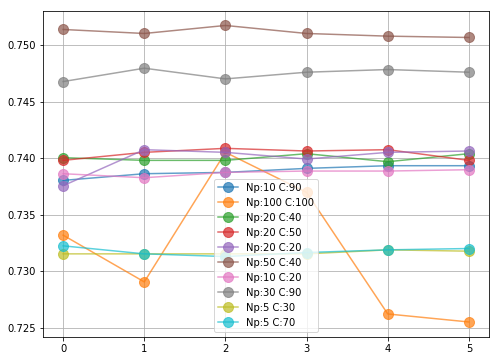

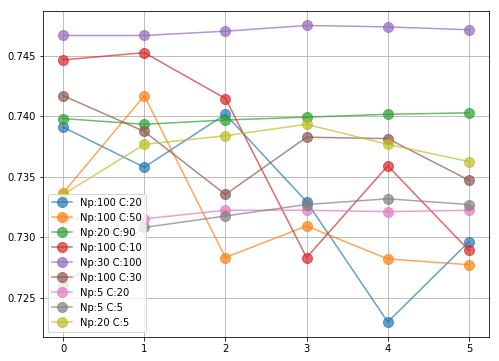

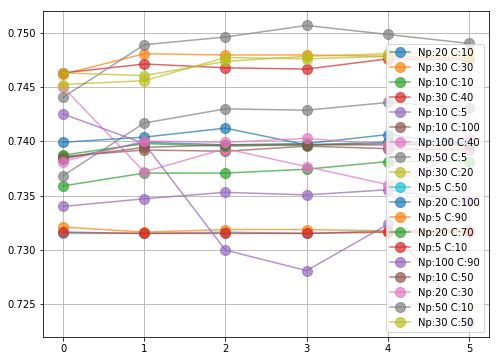

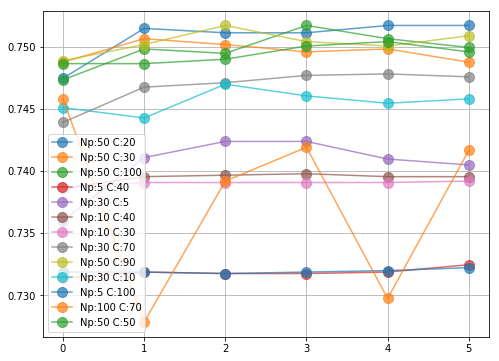

In [29]:
fig,ax = plt.subplots(figsize = (8,6))
fig1,ax1 = plt.subplots(figsize = (8,6))
fig2,ax2 = plt.subplots(figsize = (8,6))
fig3,ax3 = plt.subplots(figsize = (8,6))
for i,sim in enumerate(sims):
    if i<10:
        ax.plot(train[i],marker = "o",markersize=10,label = "Np:"+str(sim.npass)+" C:"+str(sim.cutoff),alpha = 0.7)
    if i>10 and i<20:
        ax1.plot(train[i],marker = "o",markersize=10,label = "Np:"+str(sim.npass)+" C:"+str(sim.cutoff),alpha = 0.7)
    if i>20 and i < 40:
        ax2.plot(train[i],marker = "o",markersize=10,label = "Np:"+str(sim.npass)+" C:"+str(sim.cutoff),alpha = 0.7)
    if i>40:
        ax3.plot(train[i],marker = "o",markersize=10,label = "Np:"+str(sim.npass)+" C:"+str(sim.cutoff),alpha = 0.7)

ax.grid()
ax.legend()
ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
ax3.grid()
ax3.legend()

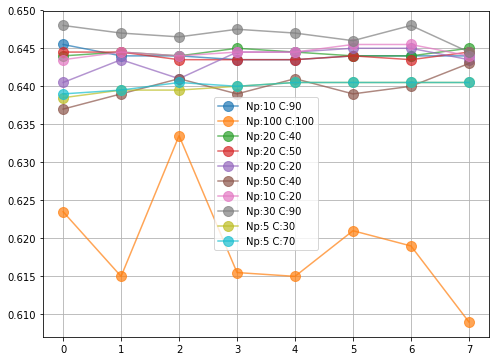

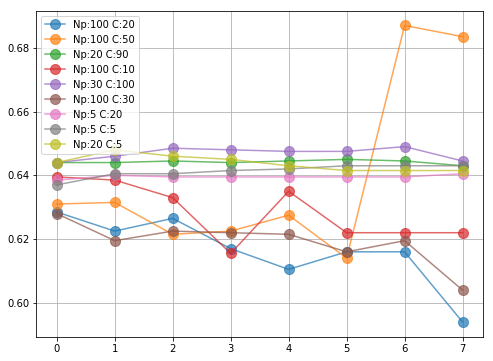

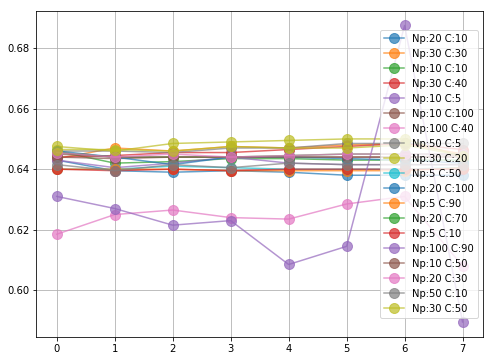

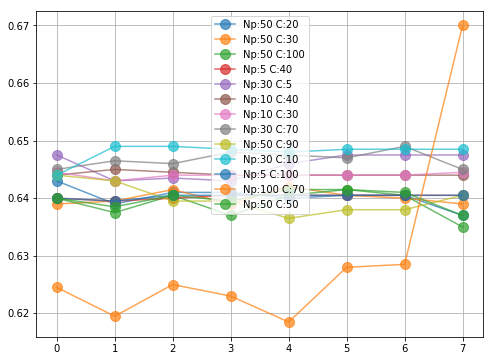

In [30]:
fig,ax = plt.subplots(figsize = (8,6))
fig1,ax1 = plt.subplots(figsize = (8,6))
fig2,ax2 = plt.subplots(figsize = (8,6))
fig3,ax3 = plt.subplots(figsize = (8,6))
for i,sim in enumerate(sims):
    if i<10:
        ax.plot(test[i],marker = "o",markersize=10,label = "Np:"+str(sim.npass)+" C:"+str(sim.cutoff),alpha = 0.7)
    if i>10 and i<20:
        ax1.plot(test[i],marker = "o",markersize=10,label = "Np:"+str(sim.npass)+" C:"+str(sim.cutoff),alpha = 0.7)
    if i>20 and i < 40:
        ax2.plot(test[i],marker = "o",markersize=10,label = "Np:"+str(sim.npass)+" C:"+str(sim.cutoff),alpha = 0.7)
    if i>40:
        ax3.plot(test[i],marker = "o",markersize=10,label = "Np:"+str(sim.npass)+" C:"+str(sim.cutoff),alpha = 0.7)

ax.grid()
ax.legend()
ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
ax3.grid()
ax3.legend()

In [63]:
entropy = np.loadtxt("../X_sim/outX/sim10/entropy_c10_n50_l0.2d0_t1D-3_f1_s2.out")

In [64]:
for e in entropy:
    if e[0] == 0:
        e[0] = 5

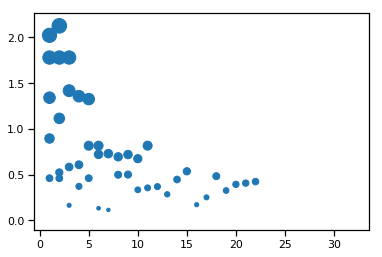

In [66]:
plt.scatter(entropy[:,1],entropy[:,2],s = 100*entropy[:,2])

In [67]:
en = entropy[:32,2]

In [68]:
rank = []
for i in range(32):
    n = en[i]
    count = 0
    for j in range(32):
        if (n<en[j]):
            count += 1
    rank.append(count)   

In [2]:
label = [ 'ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
       'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance',"","","","","","","","",""]

([<matplotlib.axis.XTick at 0x7efe0e1dabe0>,
 <a list of 32 Text xticklabel objects>)

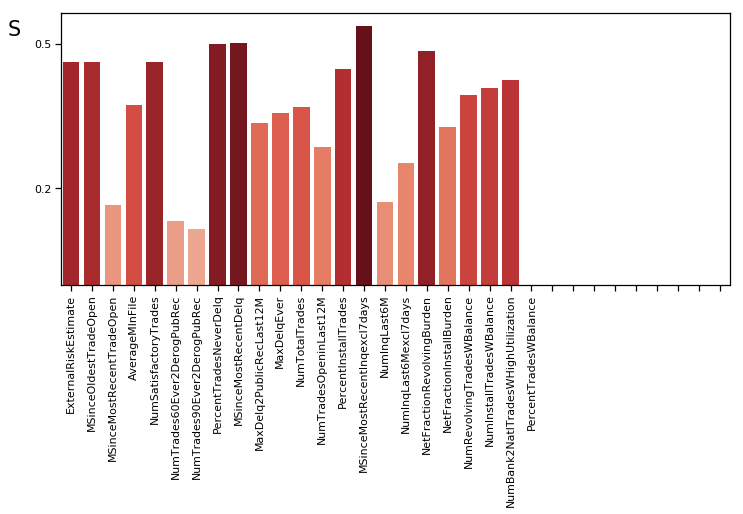

In [70]:
f = plt.figure(figsize=(12, 5))
pal = sns.color_palette("Reds",32)
sns.set_context("notebook")
bar = sns.barplot(np.arange(0,32),entropy[:32,2], palette=np.array(pal[::-1])[rank] )
bar.set(ylabel="S")
bar.set_yticks([0.2,0.5])
bar.set_ylabel(bar.get_ylabel(),bar.yaxis.set_label_coords(-0.07,0.9), fontsize='xx-large', rotation="horizontal")
plt.xticks(ticks=np.arange(0,32),labels=label,rotation=90)
#plt.savefig("C"+str(c)+"_N"+str(N)+"entropy.png",format="png")

In [7]:
def read_corr(filename):
    corr = []
    with open(filename,"r") as f:
            cl = []
            line = f.readline()
            cl.append(int(line.strip(" ").split(" ")[0]))
            for n in line.strip(" ").split(" ")[1:]:
                if n != "":
                    cl.append(int(n))
            #corr.append(cl)
            ii = 2
            for line in f:
                for n in line.strip(" ").split(" "):
                    if (n != "") & (n != "\n"):
                        if ii < 2:
                            cl.append(int(n))
                        else:
                            cl.append(float(n))
                        ii+=1
                if ii == 6:
                    corr.append(cl)
                    cl = []
                    ii = 0
    return corr    

In [8]:
corr = read_corr("../XTTN/out/correlations.out")
norm = np.loadtxt("../XTTN/out/correlations.outnorms")
sz = read_corr("../XTTN/out/correlations.outsigz")

ValueError: Wrong number of columns at line 2

In [15]:
N1,n12,n12,N2 = norm

In [25]:
norm

array([110.93426967, -93.16739607, -93.16739607, 117.9492013 ])

In [26]:
corr

[[1,
  2,
  -19.8080073328164,
  19.1883240929178,
  19.1883240929172,
  -26.3607597172424],
 [1,
  3,
  -52.6589253132766,
  45.628818528836,
  45.6288185288365,
  -56.6365458136972],
 [1,
  4,
  -22.9361269865623,
  21.152609635296,
  21.1526096352961,
  -29.1801397731297],
 [1,
  5,
  -13.3126451615983,
  14.9577766820495,
  14.9577766820497,
  -22.4191260555172],
 [1,
  6,
  -24.4153292161967,
  20.8306994866876,
  20.8306994866878,
  -25.9103775359122],
 [1,
  7,
  -26.2897326884024,
  23.0730401602674,
  23.0730401602674,
  -28.2417141257842],
 [1,
  8,
  35.8489933979563,
  -29.501438470324,
  -29.501438470324,
  41.5394820161049],
 [1,
  9,
  -26.4366751215695,
  22.2661630539568,
  22.2661630539569,
  -28.065913079705],
 [1,
  10,
  42.0628325255031,
  -34.5275654031258,
  -34.5275654031253,
  44.8587585523216],
 [1,
  11,
  43.5395823494411,
  -37.474188527044,
  -37.4741885270445,
  46.6173350613699],
 [1,
  12,
  -24.8268258640047,
  25.6303191204609,
  25.6303191204612,
  

In [41]:
nsites = 32
l1,l2,cross = np.zeros((nsites,nsites)), np.zeros((nsites,nsites)), np.zeros((nsites,nsites))                
  
for lin in corr:
    l1[lin[0]-1,lin[1]-1] = ((lin[2]) / (np.sqrt(abs(N1)**2)))# - (sz[lin[0]-1][0]*sz[lin[1]-1][0])/np.sqrt(N1**2)
    l2[lin[0]-1,lin[1]-1] = ((lin[-1]) / (np.sqrt(abs(N2)**2)))# - (sz[lin[0]-1][-1]*sz[lin[1]-1][-1])/np.sqrt(N2**2)
    cross[lin[0]-1,lin[1]-1] = ((lin[3]) / (np.sqrt(abs(n12)**2)))# - (sz[lin[0]-1][1]*sz[lin[1]-1][1])/np.sqrt(N1**1 * N2**1)

In [42]:
l1

array([[ 0.        , -0.17855625, -0.47468582, ..., -0.53241463,
        -0.53241463, -0.53241463],
       [ 0.        ,  0.        ,  0.3898957 , ...,  0.44034939,
         0.44034939,  0.44034939],
       [ 0.        ,  0.        ,  0.        , ...,  0.92379497,
         0.92379497,  0.92379497],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

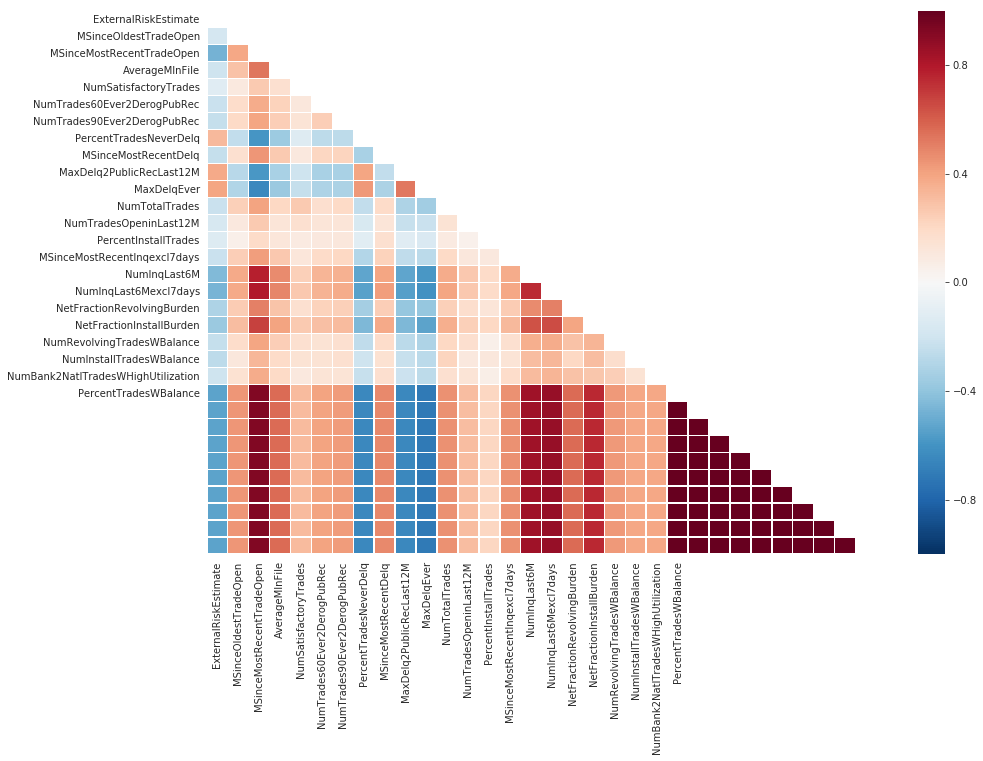

In [44]:
title=""
aa =label
mask = np.zeros_like(cross.T)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (15,10) )
    #ax.set_title(title+"Label -1 correlations",fontsize =25)
    ax = sns.heatmap(l1.T,annot=False, mask=mask,linewidth=0.5,xticklabels = aa, yticklabels = aa,cmap="RdBu_r",center = 0, vmin = -1, vmax=1)
#fig.savefig(title+"corrl1.pdf",format="pdf")    

In [1]:
title=""
aa =label
mask = np.zeros_like(l2.T)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (15,10) )
    ax.set_title(title+"Label 2 correlations",fontsize =25)
    ax = sns.heatmap(l2.T,annot=False, mask=mask,linewidth=0.5,xticklabels = aa, yticklabels = aa,cmap="RdBu_r",center = 0, vmin = -1, vmax=1)
#fig.savefig(title+"corrl1.pdf",format="pdf") 

NameError: name 'label' is not defined